In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import defaultdict
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('PyTorch/GPU')
else:
    device = torch.device('cpu')
    print('PyTorch/CPU')

PyTorch/CPU


In [3]:
config = {
    'batch_size': 32,
    'learning_rate': 0.0002,
    'epochs': 10,
    'latent_size': 100,
    'data_size': 344,
    'model_dir': './',
    'embeding_size': 2,
}

In [4]:
features_df = pd.read_csv('preprocessed_train_df.csv')
print("features shape:", features_df.shape)

target_df = pd.read_csv('y_train_df.csv')
print("available target lables:", target_df.columns.tolist())

sel_label =  'Valence'
print(f"selected target label is '{sel_label}'")

features shape: (1152, 344)
available target lables: ['Valence', 'Arousal', 'Dominance', 'Liking']
selected target label is 'Valence'


In [5]:
class DatasetDEAP(Dataset):
    
    def __init__(self, features_df, target_df, transform=None):
        assert len(features_df) == len(target_df)
        self.features = torch.FloatTensor(features_df.values)
        self.target = torch.FloatTensor(target_df.values)
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        features_ = self.features[index]
        if self.transform is not None:
            features_ = self.transform(features_)
        return features_, self.target[index]
    

data = DatasetDEAP(features_df, target_df["Arousal"])
data_loader = DataLoader(data, batch_size=config['batch_size'], shuffle=True)

In [6]:
batches = enumerate(data_loader)
batch_idx, (features_batch, target_batch) = next(batches)
print(features_batch.data.shape)
print(torch.min(features_batch.data), torch.max(features_batch.data))

torch.Size([32, 344])
tensor(-1.) tensor(1.)


In [7]:
class Generator(nn.Module):
    
    def __init__(self, input_size=config['latent_size'], embeding_size=config['embeding_size'],
                 output_size=config['data_size'], hidden_size=128):
        super(Generator, self).__init__()
        self.label_embeding = nn.Embedding(embeding_size, embeding_size)
        self.net = nn.Sequential(
                                 nn.Linear(input_size + embeding_size, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size*2, output_size),
                                 nn.Tanh()
                                )
        
    def forward(self, x, y):
        e = self.label_embeding(y)
        x = torch.cat([x, e], dim=1)
        x = self.net(x)
        return x

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size=config['data_size'], embeding_size=config['embeding_size'], hidden_size=128):
        super(Discriminator, self).__init__()
        self.label_embeding = nn.Embedding(embeding_size, embeding_size)
        self.net = nn.Sequential(
                                 nn.Linear(input_size + embeding_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size*2, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size, 1),
                                 nn.Sigmoid()
                                )
        
    def forward(self, x, y):
        e = self.label_embeding(y)
        x = torch.cat([x, e], dim=1)
        x = self.net(x)
        return x

In [9]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['learning_rate'])
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'])

criterion = torch.nn.BCELoss()

In [10]:
def train_cgan(generator=generator, discriminator=discriminator, real_train_loader=data_loader, 
               batch_size=config['batch_size'], latent_size=config['latent_size'], 
               embeding_size=config['embeding_size'], num_epochs=10, save_models=True, 
               plot_losses=True, device='cpu'):
    
    generator.to(device)
    discriminator.to(device)
    
    # loop over epochs
    history = defaultdict(list)
    for epoch in range(num_epochs):
        
        d_loss = 0.
        g_loss = 0.

        # loop over batches in each epoch
        for (features, target) in real_train_loader:
            
            features = features.view(batch_size, -1).to(device)
            target = target.view(batch_size).type(torch.LongTensor).to(device)
            
            # train discriminator
            # --------------------------
            discriminator.train()
            generator.eval()
            
            preds = discriminator(features, target)
            real_loss = criterion(preds, torch.ones_like(preds).to(device))
            
            fake_target = torch.LongTensor(np.random.randint(0, embeding_size, batch_size)).to(device)
            fake_features = generator(torch.randn(batch_size, latent_size).to(device), fake_target)
            fake_preds = discriminator(fake_features, fake_target)
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds).to(device))
            
            discriminator_loss = real_loss + fake_loss
            discriminator.zero_grad();
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # train generator
            # --------------------------
            generator.train()
            discriminator.eval()
            
            forged_target = torch.LongTensor(np.random.randint(0, embeding_size, batch_size)).to(device)
            forged_feafures = generator(torch.randn(batch_size, latent_size).to(device), forged_target)
            forged_preds = discriminator(forged_feafures, forged_target)
            forged_loss = criterion(forged_preds, torch.ones_like(forged_preds).to(device))
            
            generator.zero_grad();
            forged_loss.backward()
            generator_optimizer.step()
            
            # losses
            d_loss += discriminator_loss
            g_loss += forged_loss
            
        # statistics
        d_loss /= len(real_train_loader)
        g_loss /= len(real_train_loader)   
        print("epoch: {}/{}, d_loss:{:.5f}, g_loss:{:.5f}".format(epoch+1, num_epochs, d_loss, g_loss))
        history['g_losses'].append(g_loss.data.item())
        history['d_losses'].append(d_loss.data.item())
        
    # Save the model checkpoints 
    if save_models:
        torch.save(generator.state_dict(), 'model-gen.ckpt')
        torch.save(discriminator.state_dict(), 'model-discr.ckpt')
    
    # plot losses
    if plot_losses:
        plt.plot(history['g_losses'], label='generator')
        plt.plot(history['d_losses'], label='discriminator')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    
    return history

epoch: 1/500, d_loss:0.98563, g_loss:0.64358
epoch: 2/500, d_loss:1.11862, g_loss:0.63599
epoch: 3/500, d_loss:0.97876, g_loss:0.95607
epoch: 4/500, d_loss:0.99882, g_loss:0.98227
epoch: 5/500, d_loss:0.67721, g_loss:1.56091
epoch: 6/500, d_loss:0.46049, g_loss:2.35137
epoch: 7/500, d_loss:0.20952, g_loss:3.14825
epoch: 8/500, d_loss:0.28481, g_loss:2.68396
epoch: 9/500, d_loss:0.59422, g_loss:2.12557
epoch: 10/500, d_loss:1.00830, g_loss:1.75173
epoch: 11/500, d_loss:1.36187, g_loss:1.38900
epoch: 12/500, d_loss:1.13844, g_loss:1.36260
epoch: 13/500, d_loss:0.87512, g_loss:1.56338
epoch: 14/500, d_loss:1.08090, g_loss:1.09018
epoch: 15/500, d_loss:0.68796, g_loss:1.61741
epoch: 16/500, d_loss:0.72445, g_loss:1.64134
epoch: 17/500, d_loss:0.40941, g_loss:2.28444
epoch: 18/500, d_loss:0.53514, g_loss:1.97654
epoch: 19/500, d_loss:0.54458, g_loss:2.11376
epoch: 20/500, d_loss:0.50417, g_loss:2.31766
epoch: 21/500, d_loss:0.77587, g_loss:1.62581
epoch: 22/500, d_loss:0.54798, g_loss:1.945

epoch: 351/500, d_loss:1.19851, g_loss:0.94432
epoch: 352/500, d_loss:1.39167, g_loss:0.71649
epoch: 353/500, d_loss:1.09930, g_loss:1.04087
epoch: 354/500, d_loss:1.36346, g_loss:0.72124
epoch: 355/500, d_loss:1.25029, g_loss:0.88090
epoch: 356/500, d_loss:1.27915, g_loss:0.86580
epoch: 357/500, d_loss:1.34815, g_loss:0.74741
epoch: 358/500, d_loss:1.16043, g_loss:0.97833
epoch: 359/500, d_loss:1.34613, g_loss:0.77058
epoch: 360/500, d_loss:1.17382, g_loss:1.02192
epoch: 361/500, d_loss:1.35159, g_loss:0.76330
epoch: 362/500, d_loss:1.26041, g_loss:0.90864
epoch: 363/500, d_loss:1.25601, g_loss:0.82547
epoch: 364/500, d_loss:1.27431, g_loss:0.85780
epoch: 365/500, d_loss:1.28000, g_loss:0.84152
epoch: 366/500, d_loss:1.26348, g_loss:0.90597
epoch: 367/500, d_loss:1.21697, g_loss:0.88642
epoch: 368/500, d_loss:1.30557, g_loss:0.83945
epoch: 369/500, d_loss:1.20720, g_loss:0.91199
epoch: 370/500, d_loss:1.29975, g_loss:0.76228
epoch: 371/500, d_loss:1.19768, g_loss:0.93934
epoch: 372/50

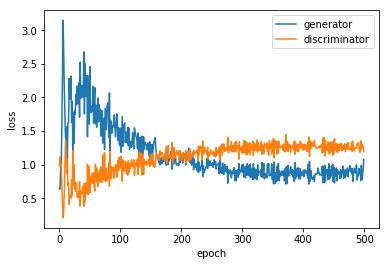

In [11]:
history = train_cgan(num_epochs=500, device=device)

In [12]:
def generate_cgan_data(generator=generator, n_samples=1, latent_size=config['latent_size'], 
                      embeding_size=config['embeding_size'], device='cpu'):
    
    gan_target = torch.LongTensor(np.random.randint(0, embeding_size, n_samples)).to(device)
    gan_feafures = generator(torch.randn(n_samples, latent_size).to(device), gan_target)
    return np.array(gan_feafures.data), np.array(gan_target)

GAN shape: (5000, 344)


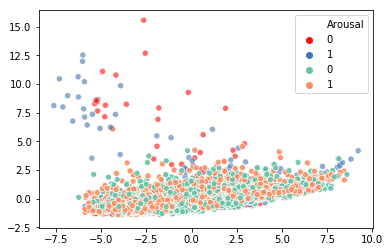

In [13]:
# real data
pca = PCA(n_components=2)
pca.fit(features_df.values)
features_pca = pca.transform(features_df.values)
sns.set_palette(sns.color_palette(["#FF0B04", "#4374B3"]))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target_df['Arousal'], alpha=0.6)

# GAN data
gan_features, gan_target = generate_cgan_data(n_samples=5000)
print("GAN shape:", gan_features.shape)
gan_features_pca = pca.transform(gan_features)
sns.set_palette(sns.color_palette("Set2"))
sns.scatterplot(x=gan_features_pca[:, 0], y=gan_features_pca[:, 1], hue=gan_target,
                color='k', alpha=0.9);

In [14]:
cgan_features_df = pd.DataFrame(gan_features, columns=features_df.columns)
cgan_features_df.to_csv("cgan_features_train.csv", index=False)
                                 
cgan_target_df = pd.DataFrame({sel_label: gan_target})
cgan_target_df.to_csv("cgan_target_train.csv", index=False)
# cgan_target_df.head()